<a href="https://colab.research.google.com/github/mtxslv/digitalprocessingsimulations/blob/master/IIRstopbandFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações de módulos

In [0]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Audio
Para lidarmos com áudio, vamos usar o arquivo que utilizamos na [implementação anterior](https://github.com/mtxslv/digitalprocessingsimulations/blob/master/band_stopFilter.ipynb).

In [0]:
# Algumas importações
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
#PERMISSÃO PRA USAR ARQUIVOS

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from scipy.io import wavfile
fs, data = wavfile.read('/content/drive/My Drive/Colab Notebooks/Project_Files/audio2pds.wav')# fs = 8000, data.shape = (48640,)

In [0]:
t = np.linspace(0,6, data.shape[0]) # amostras de tempo pro ruído
ruido = 9000*np.cos(2*np.pi*2000*t) #gerando ruído de 2kHz
audio_ruidoso = data + ruido # unindo ruído com o próprio áudio

# Cálculos Iniciais:

## Especificações do filtro IIR
Pro filtro IIR, é necessário sabermos a variação que nosso sinal vai sofrer (pulsação) na banda de passagem e na banda de rejeição. Chamemos duas variáveis, epsilon (pra banda de passagem) e delta (pra banda de rejeição). De forma a compararmos com o [filtro FIR anteriormente realizado](https://github.com/mtxslv/digitalprocessingsimulations/blob/master/band_stopFilter.ipynb), faremos:

In [0]:
# Limites de pulsação
epsilon = 0.02 # Na banda de passagem
delta = 0.01 # Na banda de rejeição

##Cálculo dos amortecimentos (dB) e das frequências importantes
Ora, os amortecimentos são importantes pra se calcular a ordem do [filtro](https://en.wikipedia.org/wiki/Butterworth_filter). As frequências de rejeição e passagem nos indicam onde "cortar" as componentes do sinal.

In [0]:
ganho_pas = 20*np.log10(1-epsilon) # ~-0.1755
ganho_rej = 20*np.log10(delta) # -40

In [0]:
omega_pas = [0.35, 0.65]
omega_rej = [0.4, 0.6]

##Breve nota sobre equações de diferenças...
O resultado acima alcançado já nos dá os coeficientes $b_k$ e $a_k$ da equação:

 >>>  $H(z) = \frac{Y(z)}{X(z)} = \frac{B(z)}{A(z)}=   \frac{\sum_{k=0}^{M}b_kz^-k}{1 + \sum_{k=1}^{N}a_kz^-k}  $
 
 A partir da transformada $Z$ inversa, chegamos a:
 >>> $ y[n] = \sum_{k=0}^{M}b_kx[n-k] - \sum_{k=1}^Na_ky[n-k]$
 
 Cuidado! A relação anterior é válida apenas porque consideramos que o somatório no denominador de $H(z)$ não está multiplicado por $-1$. Isso fica explícito ao lermos as [referências da implementação do filtro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html).

# Butterworth

## Cálculo da ordem do filtro
Para o cálculo da ordem do filtro, usaremos a função **signal.buttord**. Para mais informações sobre, [acesse aqui](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.buttord.html). 

In [0]:
N, Wn = signal.buttord(omega_pas, omega_rej, ganho_pas, ganho_rej) # N = 2, Wn = [0.08618914 0.91381099]

##Agora vamos ao *design* do filtro

Como estamos lidando com filtro butterworth, vamos utilizar uma [função pronta](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html) para o cálculo dos coeficientes do polinômio.

In [0]:
b,a = signal.butter(N,Wn,'bandstop') 
# b = [5.24319516e-02 1.61394248e-07 1.04863903e-01 1.61394248e-07 5.24319516e-02]
# a = [1.00000000e+00  5.72517329e-07 -1.25602799e+00 -2.49728833e-07 4.65755795e-01]

In [0]:
# Let's see the filter we have designed

w, H = signal.freqz(b,a, whole=True) # Whole = True will let us see the two rejections valleys.

Atenção! o comando [signal.freqz()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) amostra as frequências digitais de 0 a 2$\pi$. Assim sendo, pra visualizarmos o filtro corretamente, iremos deslocar o domínio para ($\pi , -\pi$) e dividir por $\pi$, para podermos visualizar a rejeição de faixa em $\pm0.5$.

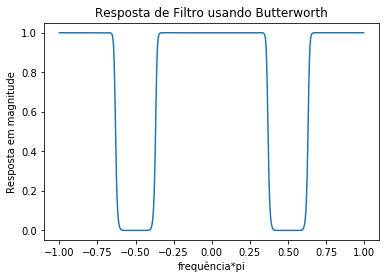

In [38]:
# Visualizando o filtro...
plt.title("Resposta de Filtro usando Butterworth")
plt.xlabel('frequência*pi')
plt.ylabel('Resposta em magnitude')
plt.plot((w-np.pi)/np.pi,np.abs(H)) # deslocamento e divisão no domínio

## Filtrando o áudio...

In [0]:
audio_filtrado_butterworth = signal.lfilter(b,a,audio_ruidoso)

In [15]:
# Audio com Ruido
Audio(audio_ruidoso, rate = fs)

In [16]:
# Audio filtrado

Audio(audio_filtrado_butterworth, rate = fs)

In [17]:
#Audio Original

Audio(data, rate = fs)

## Exibindo no domínio do tempo

In [0]:
t_filt_but = np.linspace(0,6,num = audio_filtrado_butterworth.shape[0]) 

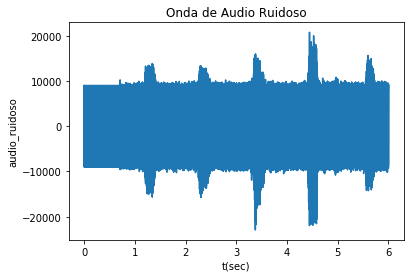

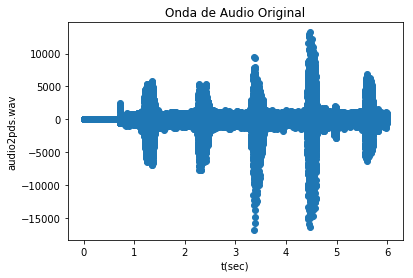

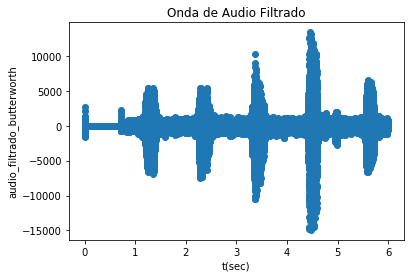

In [19]:
plt.figure(1)
plt.title("Onda de Audio Ruidoso")
plt.xlabel("t(sec)")
plt.ylabel("audio_ruidoso")
plt.plot(t,audio_ruidoso)
plt.show()

plt.figure(2)
plt.title("Onda de Audio Original")
plt.xlabel("t(sec)")
plt.ylabel("audio2pds.wav")
plt.scatter(t,data)
plt.show()

plt.figure(3)
plt.title("Onda de Audio Filtrado")
plt.xlabel("t(sec)")
plt.ylabel("audio_filtrado_butterworth")
plt.scatter(t_filt_but,audio_filtrado_butterworth)

#Chebyshev 1

##Cálculo da ordem do filtro
Para o cálculo usando método chebyshev 1, iremos usar a função **[cheb1.ord](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.cheb1ord.html)**.

In [0]:
Ncc1, Wncc1 = signal.cheb1ord(omega_pas, omega_rej, ganho_pas, ganho_rej)
# Ncc1 = 7
# Wncc1 = [0.35000193 0.64999819]

##*Design* do filtro Chebyshev

Para podermos gerar nosso filtro, iremos utilizar [uma função](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.cheby1.html).

In [0]:
b_cc1, a_cc1 = signal.cheby1(Ncc1, np.abs(20*np.log10(1-epsilon)) ,Wncc1, btype = 'bandstop')

# np.abs(20*np.log10(1-epsilon)) = 0.175478486150103 dB

# a_cc1 = [1.00000000e+00  1.84800309e-06  1.80920372e+00  3.31704064e-06
# 2.47835149e+00  3.61693239e-06  1.61657166e+00  2.15762679e-06
# 9.54713826e-01  7.86336784e-07  1.76845880e-01  1.61960927e-07
# 6.97260144e-02 -3.65525465e-08 -3.48525019e-02]

# b_cc1 = [6.30512506e-02 1.85177314e-07 4.41358754e-01 1.11106388e-06
# 1.32407626e+00 2.77765971e-06 2.20679377e+00 3.70354628e-06
# 2.20679377e+00 2.77765971e-06 1.32407626e+00 1.11106388e-06
# 4.41358754e-01 1.85177314e-07 6.30512506e-02]

In [0]:
w_cc1, H_cc1 = signal.freqz(b_cc1,a_cc1, whole=True) 
# Whole = True will let us see the two rejections valleys.

Para plotarmos nosso filtro Chebyshev 1, estamos considerando as mesmas transformações de domínio que fizemos ao exibir o filtro Butterworth.

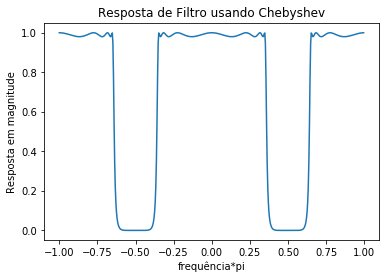

In [53]:
# Visualizando o filtro...
plt.title("Resposta de Filtro usando Chebyshev")
plt.xlabel('frequência*pi')
plt.ylabel('Resposta em magnitude')
plt.plot((w_cc1-np.pi)/np.pi,np.abs(H_cc1)) # deslocamento e divisão no domínio

##Filtrando o áudio

In [0]:
audio_filtrado_chebyshev1 = signal.lfilter(b_cc1,a_cc1,audio_ruidoso)

In [58]:
# Audio com Ruido
Audio(audio_ruidoso, rate = fs)

In [59]:
# Audio filtrado
Audio(audio_filtrado_chebyshev1, rate = fs)

In [60]:
#Audio Original
Audio(data, rate = fs)

## Exibindo no domínio do tempo

In [0]:
t_filt_cc1 = np.linspace(0,6,num = audio_filtrado_chebyshev1.shape[0]) 

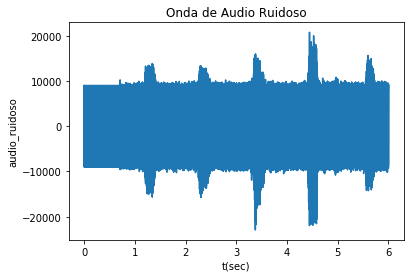

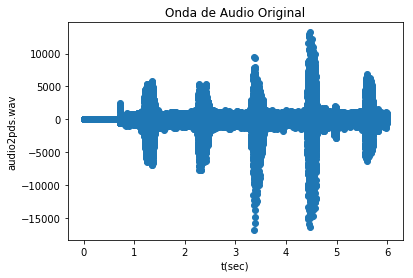

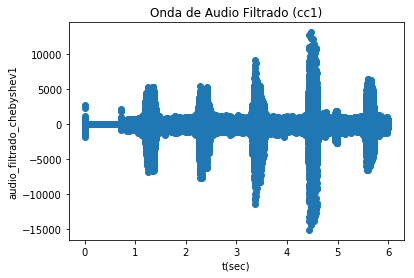

In [63]:
plt.figure(1)
plt.title("Onda de Audio Ruidoso")
plt.xlabel("t(sec)")
plt.ylabel("audio_ruidoso")
plt.plot(t,audio_ruidoso)
plt.show()

plt.figure(2)
plt.title("Onda de Audio Original")
plt.xlabel("t(sec)")
plt.ylabel("audio2pds.wav")
plt.scatter(t,data)
plt.show()

plt.figure(3)
plt.title("Onda de Audio Filtrado (cc1)")
plt.xlabel("t(sec)")
plt.ylabel("audio_filtrado_chebyshev1")
plt.scatter(t_filt_cc1,audio_filtrado_chebyshev1)